In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bisect import bisect
import seaborn as sns
import tqdm

from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

In [2]:
sns.set_context("talk")

In [3]:
client = DandiAPIClient()
# To get information about embargoed -- need to authenticate.
# If have no account, change to False to avoid consideration of embargoed dandisets
embargoed = True
only_nwb = False
if embargoed:
    client.dandi_authenticate()
dandisets_label = ("NWB " if only_nwb else "") + "Dandisets"

In [4]:
dandisets = list(client.get_dandisets(embargoed=True, empty=False))
print(f"# {dandisets_label}: {len(dandisets)}")

# Dandisets: 667


In [5]:
species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
    "Cricetulus griseus - Cricetulus aureus": "Hamster",
    "Macaca nemestrina - Pig-tailed macaque": "Macaque",
    "Macaca nemestrina - Pigtail macaque": "Macaque",
    "Macaca nemestrina": "Macaque",
    "Procambarus clarkii - Red swamp crayfish": "Crayfish",
    "Caenorhabditis elegans": "C. elegans",
    "Oryctolagus cuniculus - Rabbits": "Rabbit",
    "Ooceraea biroi - Clonal raider ant": "Ant",
}

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=["PatchClampSeries", "VoltageClampSeries", "CurrentClampSeries"],
    behav=['BehavioralEpochs', 'BehavioralEvents', 'BehavioralTimeSeries', 'Position'],
    eyetrack=['EyeTracking', 'PupilTracking'],
    optogen=['OptogeneticSeries'],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

data = defaultdict(list)
all_variables_measured = []
for dandiset in dandisets:
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    access = str(dandiset.embargo_status).split('.')[-1]
    # DEBUG printout to enable to see why some effects
    # print(f"I: {dandiset}: {dandiset.created} {dandiset.draft_version.size} {is_nwb(metadata)} {access}")
    if (only_nwb and not is_nwb(metadata)) or not dandiset.draft_version.size:
        # pbar.write(f"I: {dandiset}: skipped")
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["size"].append(dandiset.draft_version.size)
    data["access"].append(access)
    data["n_releases"].append(len([v for v in dandiset.get_versions() if v.identifier != 'draft']))
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
    
    if (variables_measured := metadata["assetsSummary"].get("variableMeasured")):
        all_variables_measured.extend(variables_measured)
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in (variables_measured or []))
        )
    
    if "numberOfSubjects" in metadata["assetsSummary"]:
        data["numberOfSubjects"].append(metadata["assetsSummary"]["numberOfSubjects"])
    else:
        data["numberOfSubjects"].append(np.nan)
    
df = pd.DataFrame.from_dict(data)

species_unique1 = df["species"].unique()
for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

species_unique2 = df["species"].unique()
# If there is both latin and then english through " - " - tak the latter
df["species"] = df["species"].apply(lambda x: isinstance(x, str) and x.rsplit(" - ", 1)[-1].strip() or x)

Other variables which were not associated with neurodata types yet:
Counter({'ProcessingModule': 254, 'ElectrodeGroup': 157, 'OpticalChannel': 96, 'ImagingPlane': 96, 'SpatialSeries': 87, 'CurrentClampStimulusSeries': 41, 'CompassDirection': 39, 'VoltageClampStimulusSeries': 33, 'OnePhotonSeries': 8, 'SpikeEventSeries': 4, 'DecompositionSeries': 3, 'Spectrum': 1})


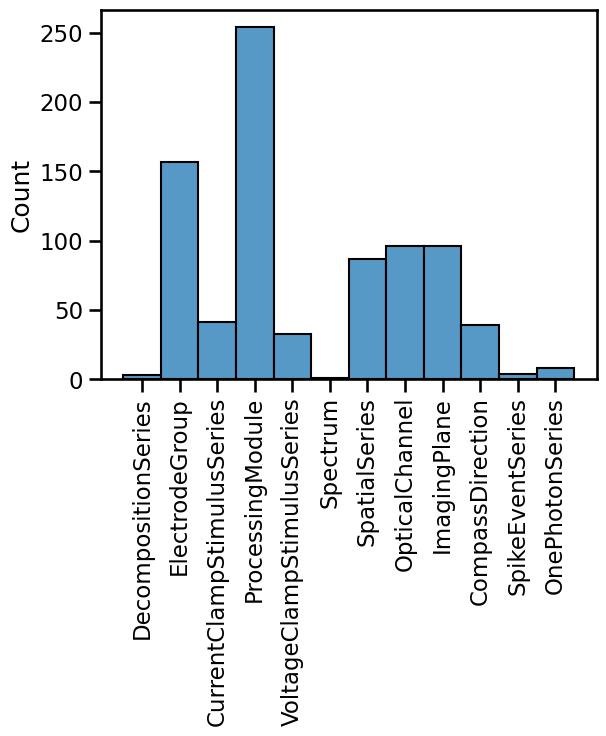

In [6]:
print("Other variables which were not associated with neurodata types yet:")
not_associated = set(all_variables_measured).difference(set(sum(neurodata_type_map.values(), [])))
all_variables_not_associated = [x for x in all_variables_measured if x in not_associated]
sns.histplot(all_variables_not_associated)
plt.xticks(rotation=90); 
from collections import Counter
print(Counter(all_variables_not_associated))

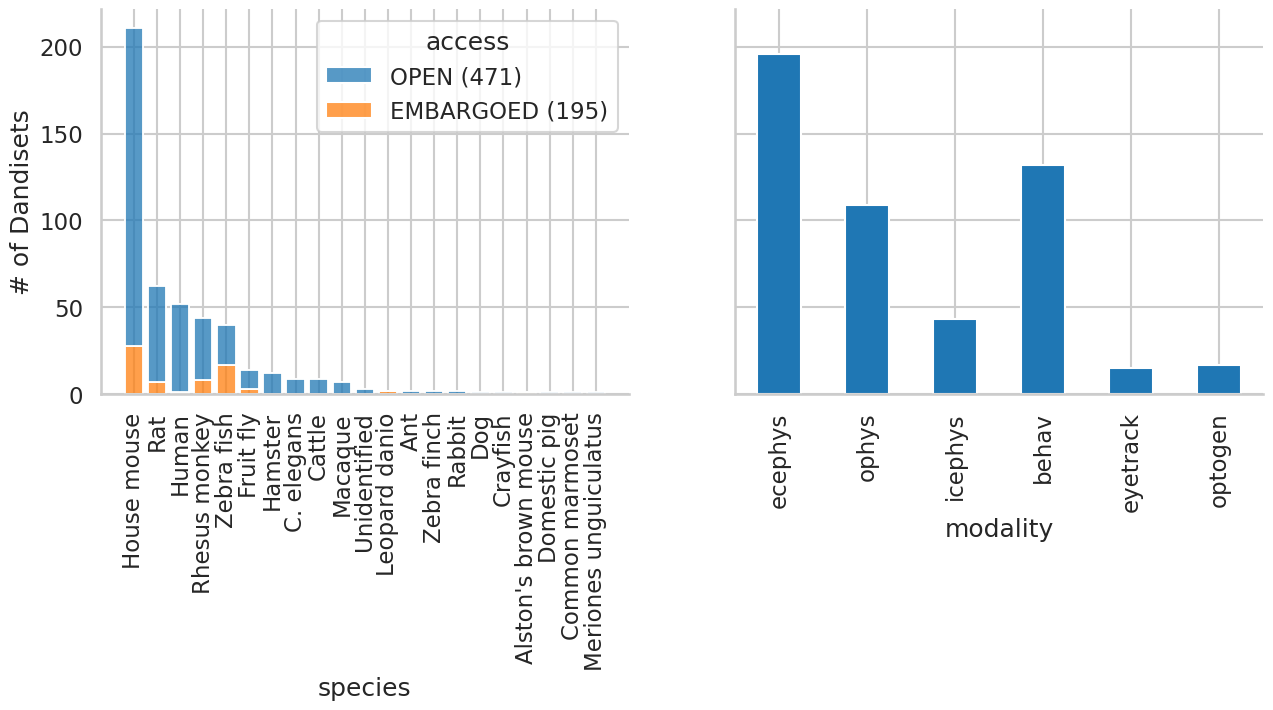

In [7]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

plt.axes(axs[0])

# Instead of this simple one, yoh decided to plot a complicated one depicting both
# OPEN and EMBARGOED across species
# ax = df["species"].value_counts().plot.bar()

# Count the occurrences of each category in 'species'
species_counts = df['species'].value_counts()
# Sort the index based on the counts, from highest to lowest
sorted_species = species_counts.index.tolist()
dfs = df.copy()
# Convert the 'species' column to a categorical type with the desired order
dfs['species'] = pd.Categorical(dfs['species'], categories=sorted_species, ordered=True)
dfs = dfs.sort_values('species')
ax = sns.histplot(data=dfs, x='species', hue='access', multiple='stack', shrink=0.8, discrete=True)
for text in ax.get_legend().texts:
    access = text.get_text()
    naccess = sum(df["access"] == access)
    text.set_text(f"{access} ({naccess})")
plt.xticks(rotation=90)  # Rotate labels if necessary
ax.set_ylabel(f"# of {dandisets_label}")
ax.set_xlabel("species")
sns.despine()

plt.axes(axs[1])
ax2 = df[list(neurodata_type_map)].sum().plot.bar()
ax2.set_xlabel("modality")
sns.despine()

if False:  # to plot embargoed stats separately as well, but numbers too high - squash prior ones
    plt.axes(axs[2])
    # Retrieve the current default color palette from seaborn
    colors = sns.color_palette()
    # Get value counts and sort the index if you want a specific order
    access_counts = df["access"].value_counts().sort_index()
    # Define colors in the order of the bars. Adjust based on your actual data order.
    # For example, if "OPEN" comes first, followed by "EMBARGOED", assign colors accordingly.
    colors = [colors[0] if x == 'OPEN' else colors[1] for x in access_counts.index]
    ax = access_counts.plot.bar(color=colors)
    # ax = df["access"].value_counts().plot.bar()
    ax.set_ylabel(f"# of {dandisets_label}")
    ax.set_xlabel("access")
    sns.despine()

ax.figure.savefig("species-modality-access.png", bbox_inches="tight")

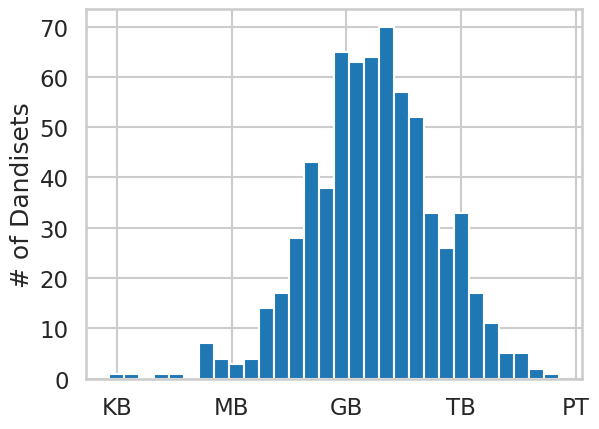

In [8]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

ax = logsize.plot.hist(bins=30)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_ylabel(f"# of {dandisets_label}")
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.figure.savefig("size.png", bbox_inches="tight")

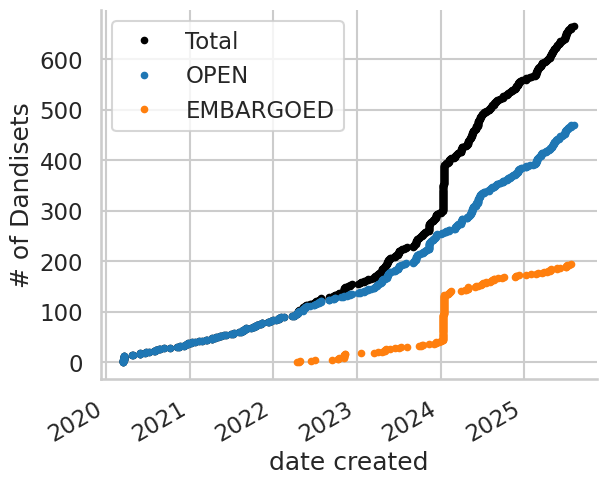

In [9]:
fig, ax = plt.subplots()

axes = {}
axes['Total'] = ax.plot(df['created'], np.arange(len(df)), 'k.')
access_types = list(df['access'].unique())
for access in access_types:
    df_ = df[df['access'] == access]
    axes[access] = ax.plot(df_['created'], np.arange(len(df_)), '.')
ax.legend(["Total"] + access_types)

for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel(f'# of {dandisets_label}')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date_count.png", bbox_inches="tight")

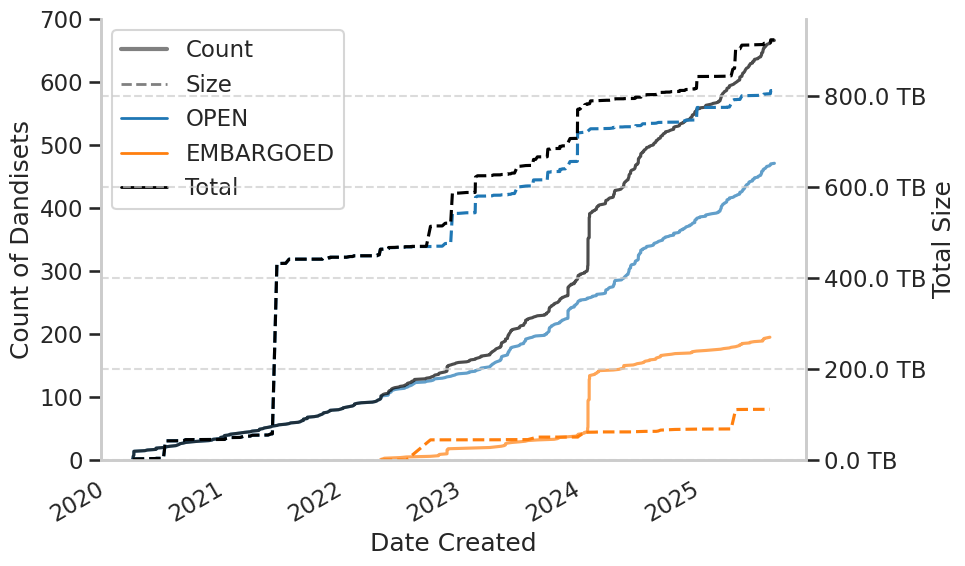

In [10]:
# More elaborate plot with also size plotted, growing based on creation time
#
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()
axes = {}

# Turn off grid lines for both axes
ax1.grid(False)
ax2.grid(False)

access_types = list(df['access'].unique())
colors = plt.cm.tab10.colors
color_map = {access: colors[i] for i, access in enumerate(access_types)}
color_map['Total'] = 'black'

# Plot data and track maximum size for proper tick setting
max_accumulated_size = 0

for i, access in enumerate(access_types + ["Total"]):
    if access == 'Total':
        df_ = df
        color = 'black'
    else:
        df_ = df[df['access'] == access]
        color = color_map[access]
    
    df_sorted = df_.sort_values(by='created')
    
    # Plot count (left axis)
    count_line, = ax1.plot(df_sorted['created'], 
                           np.arange(1, len(df_sorted) + 1), 
                           '-', 
                           color=color,
                           alpha=0.7)
    
    # Plot size (right axis)
    df_sorted['size_accumulated'] = df_sorted['size'].cumsum()
    
    # Track the maximum accumulated size
    if access == 'Total':
        max_accumulated_size = df_sorted['size_accumulated'].max()
    
    size_line, = ax2.plot(df_sorted['created'], 
                          df_sorted['size_accumulated'], 
                          '--', 
                          color=color,
                          label=f"{access}")
    
    axes[access] = [count_line, size_line]

# Format x-axis
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

# Set labels
ax1.set_ylabel(f'Count of {dandisets_label}')
ax2.set_ylabel('Total Size')
ax1.set_xlabel("Date Created")

# Format y-axis for size with human-readable values
if max_accumulated_size > 1e12:
    scale, unit = 1e12, 'TB'
elif max_accumulated_size > 1e9:
    scale, unit = 1e9, 'GB'
else:
    scale, unit = 1e6, 'MB'

# Explicitly create positive ticks for the right y-axis
# Create 6 evenly spaced ticks from 0 to max_accumulated_size
# y_ticks = np.linspace(0, max_accumulated_size, 6)
y_ticks = np.linspace(0, 10**np.ceil(np.log10(max_accumulated_size)), 6)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([f"{tick/scale:.1f} {unit}" for tick in y_ticks])
ax2.set_ylim(0, max_accumulated_size * 1.05)  # Add 5% padding at the top
ax1.set_ylim(0, len(dandisets) * 1.05)

# Add grid lines for just the right axis
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Create custom legend
solid_line = plt.Line2D([0], [0], color='gray', lw=3, linestyle='-')
dashed_line = plt.Line2D([0], [0], color='gray', lw=2, linestyle='--')

legend_elements = [solid_line, dashed_line]
legend_labels = ['Count', 'Size']

for access in access_types + ["Total"]:
    color = color_map[access]
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=2))
    legend_labels.append(access)

ax1.legend(legend_elements, legend_labels, loc='upper left')

sns.despine(right=False)
plt.tight_layout()
fig.savefig("date_count_size.png", bbox_inches="tight")

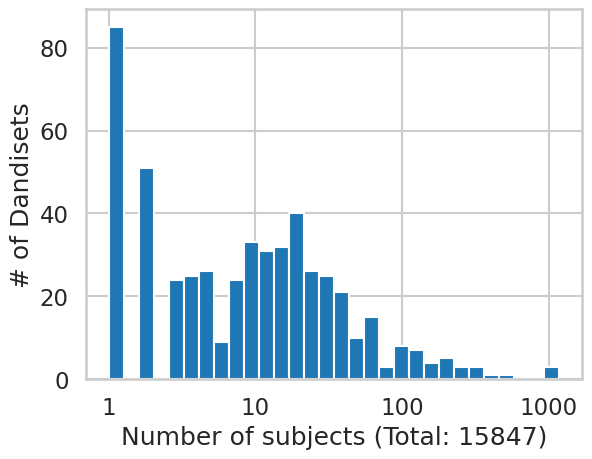

In [11]:
lognum = np.log10(df["numberOfSubjects"])

ax = lognum.plot.hist(bins=30)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_ylabel(f'# of {dandisets_label}')

ax.set_xlabel(f"Number of subjects (Total: {df['numberOfSubjects'].sum().astype(int)})")
ax.figure.savefig("subjects.png", bbox_inches="tight")